In [1]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Setup complete!")

2025-07-04 05:56:33.304613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751608593.499606      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751608593.555118      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Setup complete!


In [2]:
# Create working directory if it doesn't exist
import os
os.makedirs('/kaggle/working', exist_ok=True)
os.makedirs('/kaggle/working/logs', exist_ok=True)

print("Working directories created successfully!")
print("Files will be saved to: /kaggle/working/")

# Check available GPU memory if using GPU
if tf.config.list_physical_devices('GPU'):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")
else:
    print("No GPU detected, using CPU training")

Working directories created successfully!
Files will be saved to: /kaggle/working/
GPU memory growth enabled for 2 GPU(s)


In [3]:
# Configuration
CONFIG = {
    'data_path': '/kaggle/input/the-rvlcdip-dataset-test/test',
    'img_size': (224, 224),
    'batch_size': 32,
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    'random_state': 42
}

# Document classes in RVL-CDIP dataset
DOCUMENT_CLASSES = [
    'advertisement', 'budget', 'email', 'file_folder', 'form',
    'handwritten', 'invoice', 'letter', 'memo', 'news_article',
    'presentation', 'questionnaire', 'resume', 'scientific_publication',
    'scientific_report', 'specification'
]

print(f"Dataset path: {CONFIG['data_path']}")
print(f"Number of classes: {len(DOCUMENT_CLASSES)}")
print(f"Classes: {DOCUMENT_CLASSES}")

Dataset path: /kaggle/input/the-rvlcdip-dataset-test/test
Number of classes: 16
Classes: ['advertisement', 'budget', 'email', 'file_folder', 'form', 'handwritten', 'invoice', 'letter', 'memo', 'news_article', 'presentation', 'questionnaire', 'resume', 'scientific_publication', 'scientific_report', 'specification']


## 1. Data Loading and Exploration

Let's load the dataset and explore its structure.

In [4]:
def load_dataset(data_path):
    """
    Load all images from the dataset directory and extract labels from folder names.
    
    Returns:
        images: List of image file paths
        labels: List of corresponding labels
        class_counts: Dictionary with class distribution
    """
    images = []
    labels = []
    class_counts = {}
    
    data_path = Path(data_path)
    
    print("Loading dataset...")
    for class_name in DOCUMENT_CLASSES:
        class_path = data_path / class_name
        if class_path.exists():
            class_images = list(class_path.glob('*.tif'))
            images.extend(class_images)
            labels.extend([class_name] * len(class_images))
            class_counts[class_name] = len(class_images)
            print(f"{class_name}: {len(class_images)} images")
        else:
            print(f"Warning: {class_name} directory not found")
            class_counts[class_name] = 0
    
    print(f"\nTotal images loaded: {len(images)}")
    return images, labels, class_counts

# Load the dataset
image_paths, labels, class_distribution = load_dataset(CONFIG['data_path'])

Loading dataset...
advertisement: 2515 images
budget: 2505 images
email: 2516 images
file_folder: 2527 images
form: 2506 images
handwritten: 2532 images
invoice: 2477 images
letter: 2464 images
memo: 2492 images
news_article: 2463 images
presentation: 2489 images
questionnaire: 2435 images
resume: 2536 images
scientific_publication: 2570 images
scientific_report: 2498 images
specification: 2472 images

Total images loaded: 39997


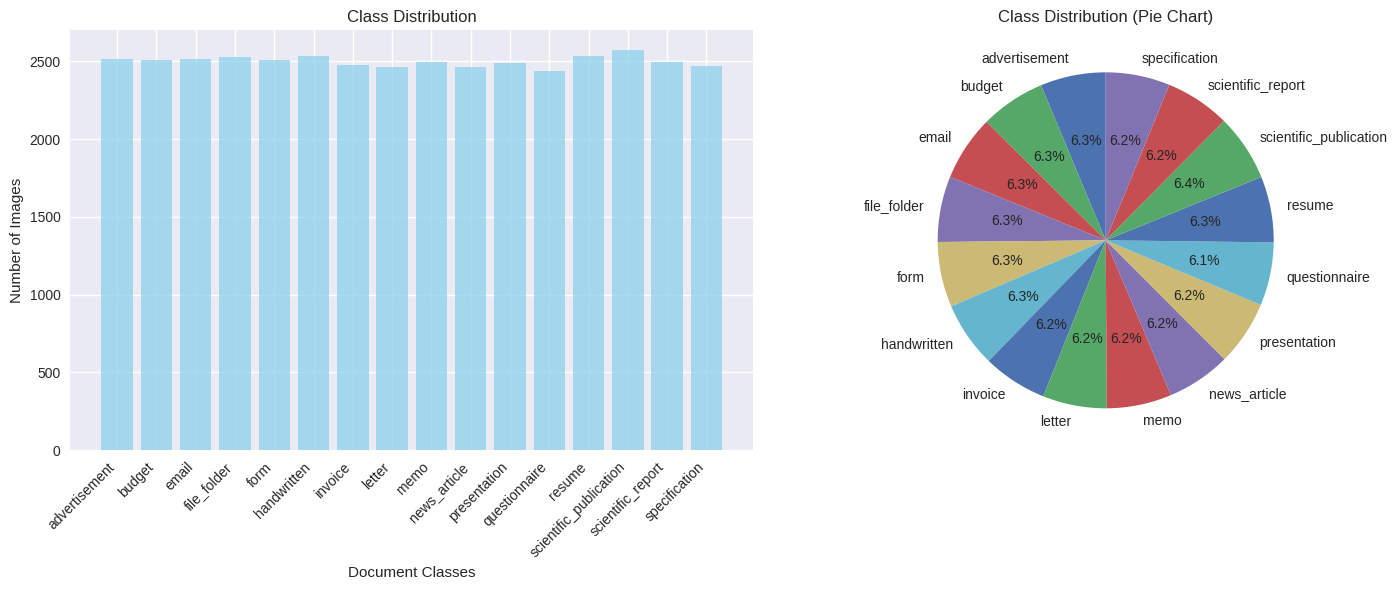


Class Distribution Summary:
                     Class  Count  Percentage
13  scientific_publication   2570    6.425482
12                  resume   2536    6.340476
5              handwritten   2532    6.330475
3              file_folder   2527    6.317974
2                    email   2516    6.290472
0            advertisement   2515    6.287972
4                     form   2506    6.265470
1                   budget   2505    6.262970
14       scientific_report   2498    6.245468
8                     memo   2492    6.230467
10            presentation   2489    6.222967
6                  invoice   2477    6.192964
15           specification   2472    6.180464
7                   letter   2464    6.160462
9             news_article   2463    6.157962
11           questionnaire   2435    6.087957


In [5]:
# Visualize class distribution
plt.figure(figsize=(15, 6))
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

plt.subplot(1, 2, 1)
plt.bar(classes, counts, color='skyblue', alpha=0.7)
plt.title('Class Distribution')
plt.xlabel('Document Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

# Create DataFrame for better analysis
df = pd.DataFrame({
    'Class': classes,
    'Count': counts,
    'Percentage': [count/sum(counts)*100 for count in counts]
})

print("\nClass Distribution Summary:")
print(df.sort_values('Count', ascending=False))

Sample images from each class:


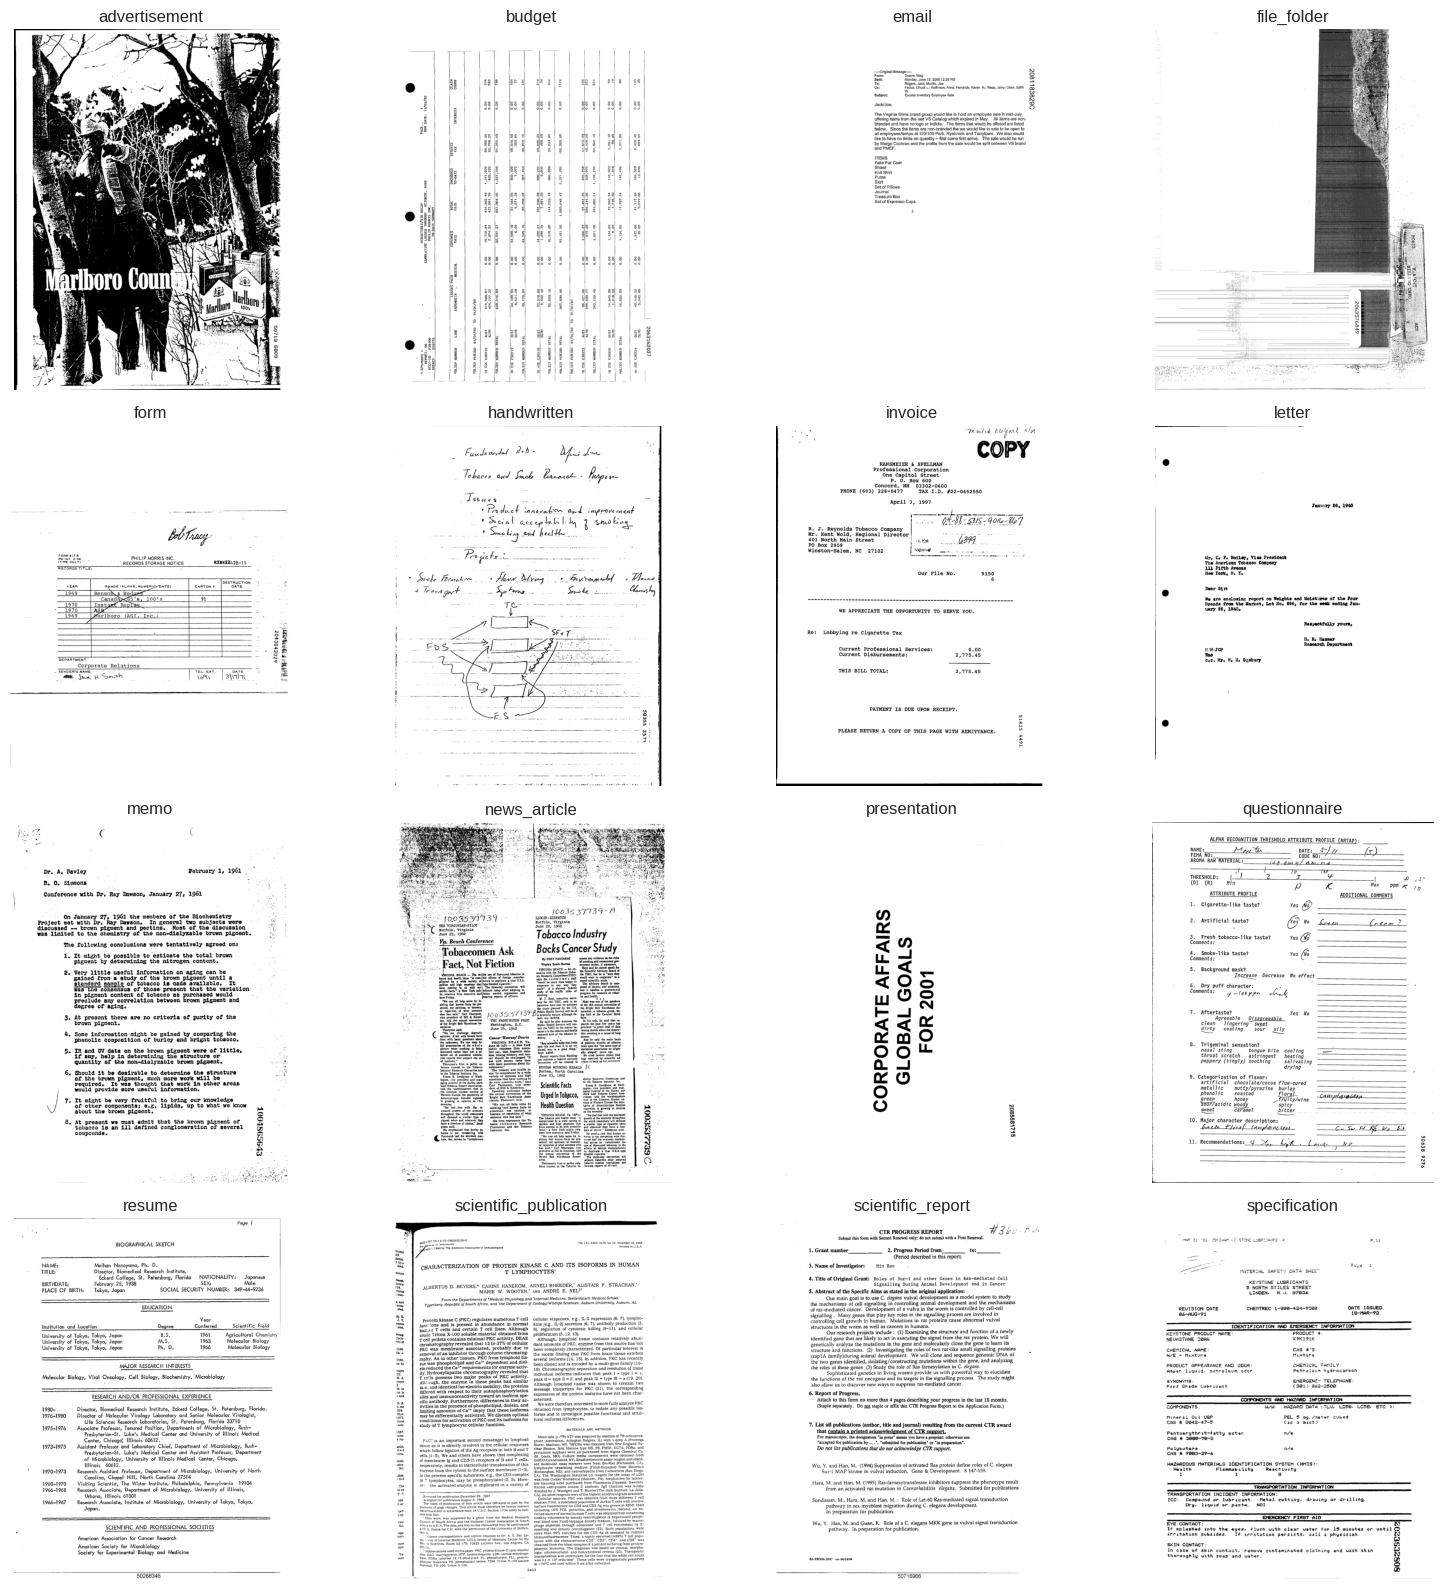

In [6]:
def visualize_samples(image_paths, labels, num_samples=16):
    """
    Visualize sample images from each class.
    """
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()
    
    # Get one sample from each class
    class_samples = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_samples:
            class_samples[label] = img_path
        if len(class_samples) >= num_samples:
            break
    
    for i, (class_name, img_path) in enumerate(class_samples.items()):
        try:
            # Load and display image
            img = Image.open(img_path)
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{class_name}', fontsize=12)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading\n{class_name}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
print("Sample images from each class:")
visualize_samples(image_paths, labels)

## 2. Data Quality Check and Preprocessing

Let's check for corrupted files and analyze image properties.

In [7]:
def check_image_quality(image_paths, labels, sample_size=1000):
    """
    Check image quality and collect statistics.
    """
    print("Checking image quality...")
    
    # Sample images for quality check
    sample_indices = np.random.choice(len(image_paths), 
                                     min(sample_size, len(image_paths)), 
                                     replace=False)
    
    valid_images = []
    valid_labels = []
    image_stats = {'widths': [], 'heights': [], 'sizes': []}
    corrupted_count = 0
    
    for idx in sample_indices:
        img_path = image_paths[idx]
        label = labels[idx]
        
        try:
            # Try to load image
            img = Image.open(img_path)
            width, height = img.size
            
            # Check if image is valid (not corrupted)
            img.verify()
            
            # Collect statistics
            image_stats['widths'].append(width)
            image_stats['heights'].append(height)
            image_stats['sizes'].append(os.path.getsize(img_path))
            
            valid_images.append(img_path)
            valid_labels.append(label)
            
        except Exception as e:
            corrupted_count += 1
            print(f"Corrupted image: {img_path}")
    
    print(f"Checked {len(sample_indices)} images")
    print(f"Valid images: {len(valid_images)}")
    print(f"Corrupted images: {corrupted_count}")
    
    # Analyze image statistics
    if image_stats['widths']:
        print(f"\nImage Statistics:")
        print(f"Width - Mean: {np.mean(image_stats['widths']):.1f}, Std: {np.std(image_stats['widths']):.1f}")
        print(f"Height - Mean: {np.mean(image_stats['heights']):.1f}, Std: {np.std(image_stats['heights']):.1f}")
        print(f"File Size - Mean: {np.mean(image_stats['sizes']):.1f} bytes, Std: {np.std(image_stats['sizes']):.1f}")
    
    return valid_images, valid_labels, image_stats

# Check image quality
valid_images, valid_labels, img_stats = check_image_quality(image_paths, labels)

Checking image quality...
Checked 1000 images
Valid images: 1000
Corrupted images: 0

Image Statistics:
Width - Mean: 765.9, Std: 20.8
Height - Mean: 1000.0, Std: 0.0
File Size - Mean: 123642.0 bytes, Std: 87637.4


In [8]:
def stratified_split(image_paths, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Perform stratified split of the dataset.
    """
    print("Performing stratified split...")
    
    # Convert to numpy arrays
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # First split: separate train+val from test
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, 
        test_size=test_ratio, 
        stratify=labels, 
        random_state=random_state
    )
    
    # Second split: separate train from val
    val_size = val_ratio / (train_ratio + val_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        test_size=val_size, 
        stratify=y_temp, 
        random_state=random_state
    )
    
    print(f"Training set: {len(X_train)} images")
    print(f"Validation set: {len(X_val)} images")
    print(f"Test set: {len(X_test)} images")
    
    # Verify class distribution
    train_dist = pd.Series(y_train).value_counts().sort_index()
    val_dist = pd.Series(y_val).value_counts().sort_index()
    test_dist = pd.Series(y_test).value_counts().sort_index()
    
    print("\nClass distribution verification:")
    split_df = pd.DataFrame({
        'Train': train_dist,
        'Validation': val_dist,
        'Test': test_dist
    })
    print(split_df)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = stratified_split(
    image_paths, labels, 
    CONFIG['train_ratio'], 
    CONFIG['val_ratio'], 
    CONFIG['test_ratio'], 
    CONFIG['random_state']
)

Performing stratified split...
Training set: 27997 images
Validation set: 6000 images
Test set: 6000 images

Class distribution verification:
                        Train  Validation  Test
advertisement            1761         377   377
budget                   1753         376   376
email                    1762         377   377
file_folder              1769         379   379
form                     1754         376   376
handwritten              1772         380   380
invoice                  1734         371   372
letter                   1724         370   370
memo                     1744         374   374
news_article             1724         370   369
presentation             1743         373   373
questionnaire            1705         365   365
resume                   1775         381   380
scientific_publication   1799         385   386
scientific_report        1748         375   375
specification            1730         371   371


In [9]:
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Preprocess a single image for VGG16.
    """
    try:
        # Load image
        img = Image.open(img_path)
        
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize
        img = img.resize(target_size)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Normalize pixel values to [0, 1]
        img_array = img_array.astype(np.float32) / 255.0
        
        return img_array
    
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        # Return a black image as fallback
        return np.zeros((*target_size, 3), dtype=np.float32)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Train labels shape: {y_train_cat.shape}")
print(f"Validation labels shape: {y_val_cat.shape}")
print(f"Test labels shape: {y_test_cat.shape}")

# Create data generators for efficient loading
def create_data_generator(image_paths, labels, batch_size=32, shuffle=True, augment=False):
    """
    Create a data generator for batch processing.
    """
    def generator():
        indices = np.arange(len(image_paths))
        
        while True:
            if shuffle:
                np.random.shuffle(indices)
            
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_images = []
                batch_labels = []
                
                for idx in batch_indices:
                    img = preprocess_image(image_paths[idx])
                    batch_images.append(img)
                    batch_labels.append(labels[idx])
                
                batch_images = np.array(batch_images)
                batch_labels = np.array(batch_labels)
                
                # Apply VGG16 preprocessing
                batch_images = tf.keras.applications.vgg16.preprocess_input(batch_images * 255.0)
                
                yield batch_images, batch_labels
    
    return generator

print("Data preprocessing setup complete!")

Number of classes: 16
Classes: ['advertisement' 'budget' 'email' 'file_folder' 'form' 'handwritten'
 'invoice' 'letter' 'memo' 'news_article' 'presentation' 'questionnaire'
 'resume' 'scientific_publication' 'scientific_report' 'specification']
Train labels shape: (27997, 16)
Validation labels shape: (6000, 16)
Test labels shape: (6000, 16)
Data preprocessing setup complete!


## 3. Dimensionality Reduction Analysis (PCA)

Let's analyze the feature space using PCA before training the model.

Performing PCA analysis on 500 samples...
Images shape for PCA: (500, 150528)
PCA completed. Shape after PCA: (500, 50)
Explained variance ratio (first 10 components): [0.26993805 0.0623378  0.04252547 0.02922281 0.02378202 0.02196901
 0.01927329 0.01562337 0.01419308 0.0133482 ]
Cumulative explained variance (first 10 components): [0.26993805 0.33227584 0.3748013  0.40402412 0.42780614 0.44977516
 0.46904844 0.4846718  0.4988649  0.5122131 ]


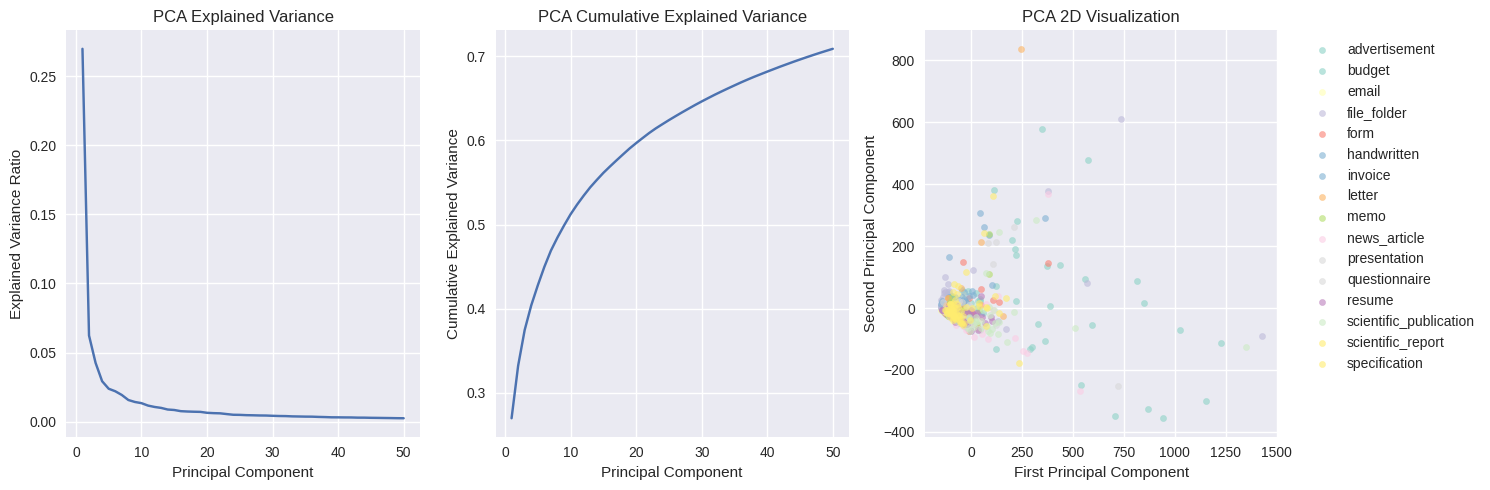

In [10]:
def perform_pca_analysis(image_paths, labels, n_samples=500, n_components=50):
    """
    Perform PCA analysis on a subset of images.
    """
    print(f"Performing PCA analysis on {n_samples} samples...")
    
    # Sample images for PCA
    sample_indices = np.random.choice(len(image_paths), 
                                     min(n_samples, len(image_paths)), 
                                     replace=False)
    
    # Load and preprocess images
    images = []
    sample_labels = []
    
    for idx in sample_indices:
        img = preprocess_image(image_paths[idx])
        images.append(img.flatten())  # Flatten for PCA
        sample_labels.append(labels[idx])
    
    images = np.array(images)
    sample_labels = np.array(sample_labels)
    
    print(f"Images shape for PCA: {images.shape}")
    
    # Standardize features
    scaler = StandardScaler()
    images_scaled = scaler.fit_transform(images)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    images_pca = pca.fit_transform(images_scaled)
    
    print(f"PCA completed. Shape after PCA: {images_pca.shape}")
    print(f"Explained variance ratio (first 10 components): {pca.explained_variance_ratio_[:10]}")
    print(f"Cumulative explained variance (first 10 components): {np.cumsum(pca.explained_variance_ratio_[:10])}")
    
    # Visualize PCA results
    plt.figure(figsize=(15, 5))
    
    # Plot explained variance
    plt.subplot(1, 3, 1)
    plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    
    # Plot cumulative explained variance
    plt.subplot(1, 3, 2)
    plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    
    # Plot 2D PCA visualization
    plt.subplot(1, 3, 3)
    unique_labels = np.unique(sample_labels)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = sample_labels == label
        plt.scatter(images_pca[mask, 0], images_pca[mask, 1], 
                   c=[colors[i]], label=label, alpha=0.6, s=20)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA 2D Visualization')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return pca, scaler, images_pca, sample_labels

# Perform PCA analysis
pca_model, scaler, pca_features, pca_labels = perform_pca_analysis(X_train, y_train)

## 4. Model Architecture

Let's build the VGG16 transfer learning model with custom classification head.

In [11]:
def create_vgg16_model(num_classes, input_shape=(224, 224, 3), 
                      dropout_rate=0.5, l2_reg=0.01):
    """
    Create VGG16 transfer learning model.
    """
    # Load VGG16 base model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Create custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Create the model
model, base_model = create_vgg16_model(num_classes)

# Display model architecture
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(var) for var in model.trainable_variables]):,}")
print(f"Non-trainable parameters: {sum([tf.size(var) for var in model.non_trainable_variables]):,}")

# Visualize model architecture
tf.keras.utils.plot_model(model, to_file='/kaggle/working/vgg16_model.png', show_shapes=True, show_layer_names=True)
print("\nModel architecture saved as '/kaggle/working/vgg16_model.png'")

I0000 00:00:1751608630.683998      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751608630.684715      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,116,880 (57.67 MB)

 Trainable params: 400,144 (1.53 MB)

 Non-trainable params: 14,716,736 (56.14 MB)


Total parameters: 15,116,880
Trainable parameters: 400,144
Non-trainable parameters: 14,716,740

Model architecture saved as '/kaggle/working/vgg16_model.png'


In [12]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Setup callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='/kaggle/working/best_vgg16_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    callbacks.CSVLogger('/kaggle/working/training_log.csv'),
    callbacks.TensorBoard(log_dir='/kaggle/working/logs', histogram_freq=1)
]

print("Training setup complete!")
print("Callbacks configured:")
for callback in callbacks_list:
    print(f"  - {callback.__class__.__name__}")

# Create data generators
train_generator = create_data_generator(X_train, y_train_cat, CONFIG['batch_size'], shuffle=True)
val_generator = create_data_generator(X_val, y_val_cat, CONFIG['batch_size'], shuffle=False)

# Calculate steps per epoch
steps_per_epoch = len(X_train) // CONFIG['batch_size']
validation_steps = len(X_val) // CONFIG['batch_size']

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Training setup complete!
Callbacks configured:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint
  - CSVLogger
  - TensorBoard

Steps per epoch: 874
Validation steps: 187


## 5. Training

Let's train the model in two phases: first with frozen base layers, then with fine-tuning.

PHASE 1: Training with frozen VGG16 base layers
Training for 20 epochs...
Epoch 1/20


I0000 00:00:1751608637.629368     103 service.cc:148] XLA service 0x7a6ae80174d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751608637.630178     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751608637.630196     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751608638.198731     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751608650.127698     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.3643 - loss: 7.2049 - top_3_accuracy: 0.5751
Epoch 1: val_accuracy improved from -inf to 0.57787, saving model to /kaggle/working/best_vgg16_model.h5
874/874 ━━━━━━━━━━━━━━━━━━━━ 721s 806ms/step - accuracy: 0.3644 - loss: 7.2022 - top_3_accuracy: 0.5752 - val_accuracy: 0.5779 - val_loss: 2.4175 - val_top_3_accuracy: 0.7858 - learning_rate: 0.0010
Epoch 2/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.5295 - loss: 2.4064 - top_3_accuracy: 0.7516
Epoch 2: val_accuracy improved from 0.57787 to 0.58322, saving model to /kaggle/working/best_vgg16_model.h5
874/874 ━━━━━━━━━━━━━━━━━━━━ 501s 559ms/step - accuracy: 0.5295 - loss: 2.4063 - top_3_accuracy: 0.7516 - val_accuracy: 0.5832 - val_loss: 2.2125 - val_top_3_accuracy: 0.7878 - learning_rate: 0.0010
Epoch 3/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5263 - loss: 2.3535 - top_3_accuracy: 0.7556
Epoch 3: val_accuracy improved from 0.58322 to 0.58723, savin

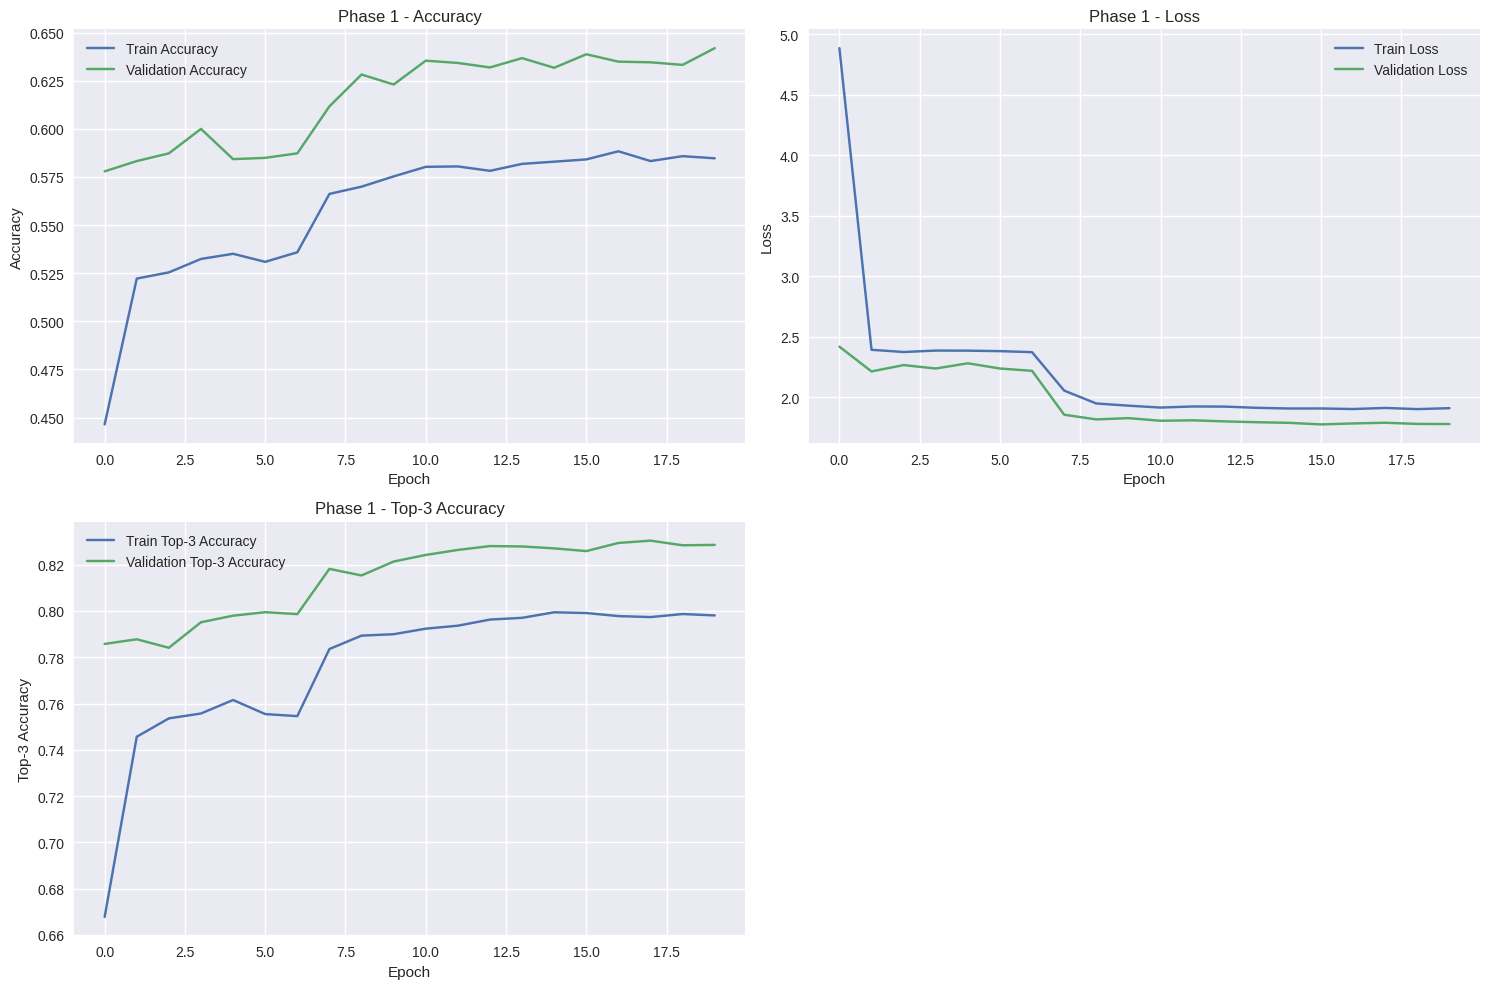

In [13]:
# Phase 1: Train with frozen base layers
print("=" * 50)
print("PHASE 1: Training with frozen VGG16 base layers")
print("=" * 50)

# Create dataset objects for better performance
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# Train Phase 1
phase1_epochs = 20
print(f"Training for {phase1_epochs} epochs...")

history_phase1 = model.fit(
    train_dataset,
    epochs=phase1_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=1
)

print("Phase 1 training completed!")

# Plot Phase 1 training history
def plot_training_history(history, phase_name):
    """Plot training history."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title(f'{phase_name} - Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title(f'{phase_name} - Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Top-3 Accuracy
    axes[1, 0].plot(history.history['top_3_accuracy'], label='Train Top-3 Accuracy')
    axes[1, 0].plot(history.history['val_top_3_accuracy'], label='Validation Top-3 Accuracy')
    axes[1, 0].set_title(f'{phase_name} - Top-3 Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-3 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], label='Learning Rate')
        axes[1, 1].set_title(f'{phase_name} - Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    else:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_phase1, "Phase 1")

PHASE 2: Fine-tuning with unfrozen top layers
Total layers in base model: 19
Trainable layers: 4

Trainable parameters after unfreezing: 7,479,568
Non-trainable parameters: 7,637,316
Fine-tuning for 15 epochs...
Epoch 1/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6221 - loss: 1.7517 - top_3_accuracy: 0.8252
Epoch 1: val_accuracy improved from -inf to 0.67981, saving model to /kaggle/working/best_vgg16_finetuned.h5
874/874 ━━━━━━━━━━━━━━━━━━━━ 468s 525ms/step - accuracy: 0.6222 - loss: 1.7515 - top_3_accuracy: 0.8252 - val_accuracy: 0.6798 - val_loss: 1.4805 - val_top_3_accuracy: 0.8600 - learning_rate: 1.0000e-04
Epoch 2/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7173 - loss: 1.3412 - top_3_accuracy: 0.8865
Epoch 2: val_accuracy improved from 0.67981 to 0.73747, saving model to /kaggle/working/best_vgg16_finetuned.h5
874/874 ━━━━━━━━━━━━━━━━━━━━ 463s 525ms/step - accuracy: 0.7174 - loss: 1.3411 - top_3_accuracy: 0.8865 - val_accuracy: 0.7375 - val_loss:

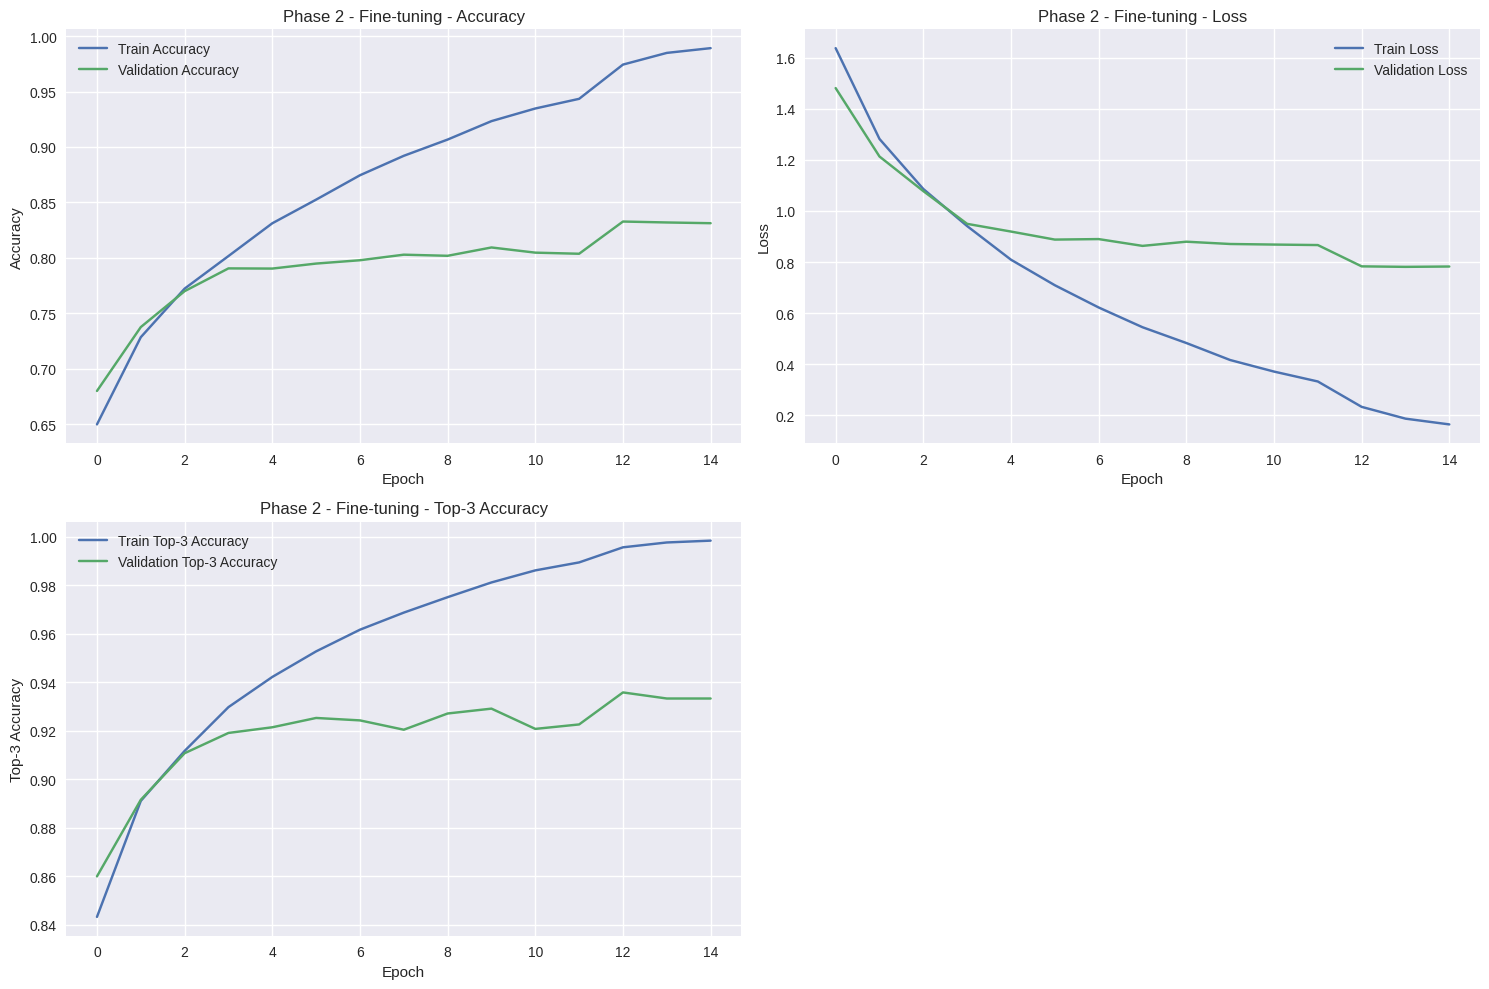

In [14]:
# Phase 2: Fine-tuning with unfrozen top layers
print("=" * 50)
print("PHASE 2: Fine-tuning with unfrozen top layers")
print("=" * 50)

# Unfreeze top layers of VGG16
base_model.trainable = True

# Freeze lower layers, unfreeze top layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print(f"\nTrainable parameters after unfreezing: {sum([tf.size(var) for var in model.trainable_variables]):,}")
print(f"Non-trainable parameters: {sum([tf.size(var) for var in model.non_trainable_variables]):,}")

# Update callbacks for fine-tuning
callbacks_phase2 = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=4,
        min_lr=1e-8,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='/kaggle/working/best_vgg16_finetuned.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train Phase 2
phase2_epochs = 15
print(f"Fine-tuning for {phase2_epochs} epochs...")

history_phase2 = model.fit(
    train_dataset,
    epochs=phase2_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks_phase2,
    verbose=1
)

print("Phase 2 fine-tuning completed!")

# Plot Phase 2 training history
plot_training_history(history_phase2, "Phase 2 - Fine-tuning")

## 6. Model Evaluation

Let's evaluate the trained model on the test set and analyze the results.

In [15]:
# Create test data generator
test_generator = create_data_generator(X_test, y_test_cat, CONFIG['batch_size'], shuffle=False)
test_steps = len(X_test) // CONFIG['batch_size']

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# Evaluate on test set
print("Evaluating model on test set...")
test_results = model.evaluate(test_dataset, steps=test_steps, verbose=1)

print(f"\\nTest Results:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Top-3 Accuracy: {test_results[2]:.4f}")

# Generate predictions for detailed analysis
print("\\nGenerating predictions for detailed analysis...")
y_pred_probs = model.predict(test_dataset, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat[:len(y_pred)], axis=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")

# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\\nDetailed Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

Evaluating model on test set...
132/187 ━━━━━━━━━━━━━━━━━━━━ 36s 671ms/step - accuracy: 0.8382 - loss: 0.7959 - top_3_accuracy: 0.9341Error processing /kaggle/input/the-rvlcdip-dataset-test/test/scientific_publication/2500126531_2500126536.tif: cannot identify image file '/kaggle/input/the-rvlcdip-dataset-test/test/scientific_publication/2500126531_2500126536.tif'
187/187 ━━━━━━━━━━━━━━━━━━━━ 126s 671ms/step - accuracy: 0.8382 - loss: 0.7941 - top_3_accuracy: 0.9336
\nTest Results:
Test Loss: 0.7894
Test Accuracy: 0.8382
Test Top-3 Accuracy: 0.9320
\nGenerating predictions for detailed analysis...
132/187 ━━━━━━━━━━━━━━━━━━━━ 22s 409ms/stepError processing /kaggle/input/the-rvlcdip-dataset-test/test/scientific_publication/2500126531_2500126536.tif: cannot identify image file '/kaggle/input/the-rvlcdip-dataset-test/test/scientific_publication/2500126531_2500126536.tif'
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 409ms/step
Predictions shape: (5984,)
True labels shape: (5984,)
\nDetailed Test Metri

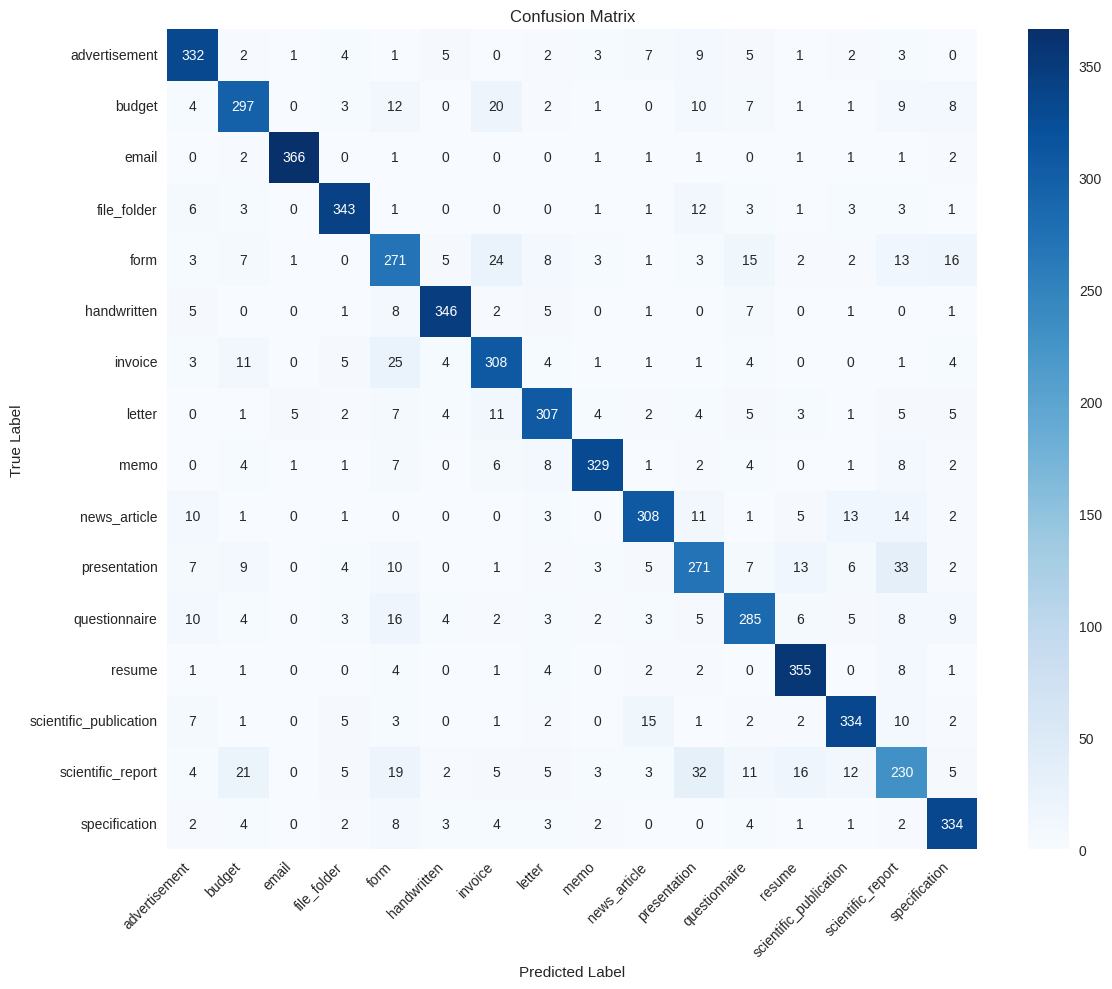

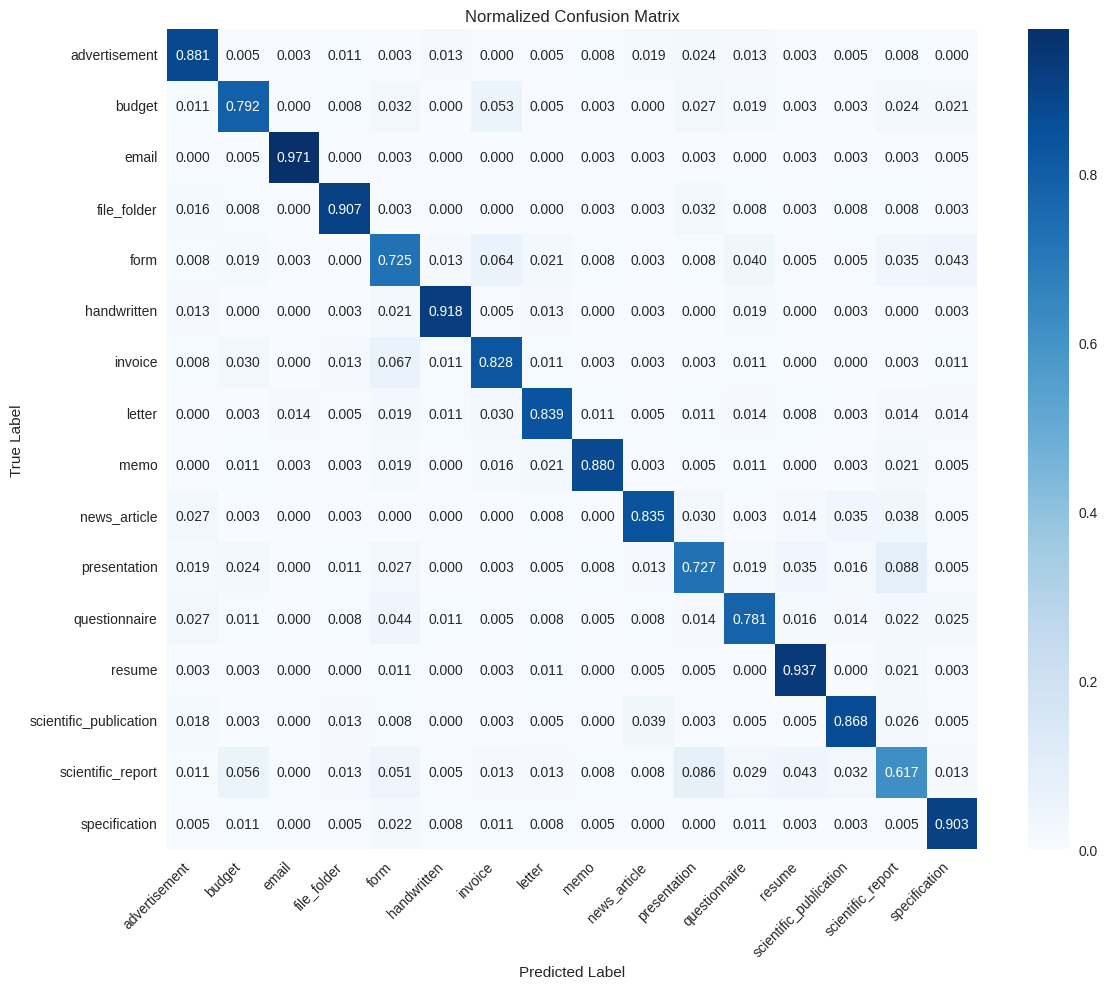


Classification Report:
                        precision    recall  f1-score   support

         advertisement       0.84      0.88      0.86       377
                budget       0.81      0.79      0.80       375
                 email       0.98      0.97      0.97       377
           file_folder       0.91      0.91      0.91       378
                  form       0.69      0.72      0.71       374
           handwritten       0.93      0.92      0.92       377
               invoice       0.80      0.83      0.81       372
                letter       0.86      0.84      0.85       366
                  memo       0.93      0.88      0.91       374
          news_article       0.88      0.83      0.86       369
          presentation       0.74      0.73      0.74       373
         questionnaire       0.79      0.78      0.79       365
                resume       0.87      0.94      0.90       379
scientific_publication       0.87      0.87      0.87       385
     scientific

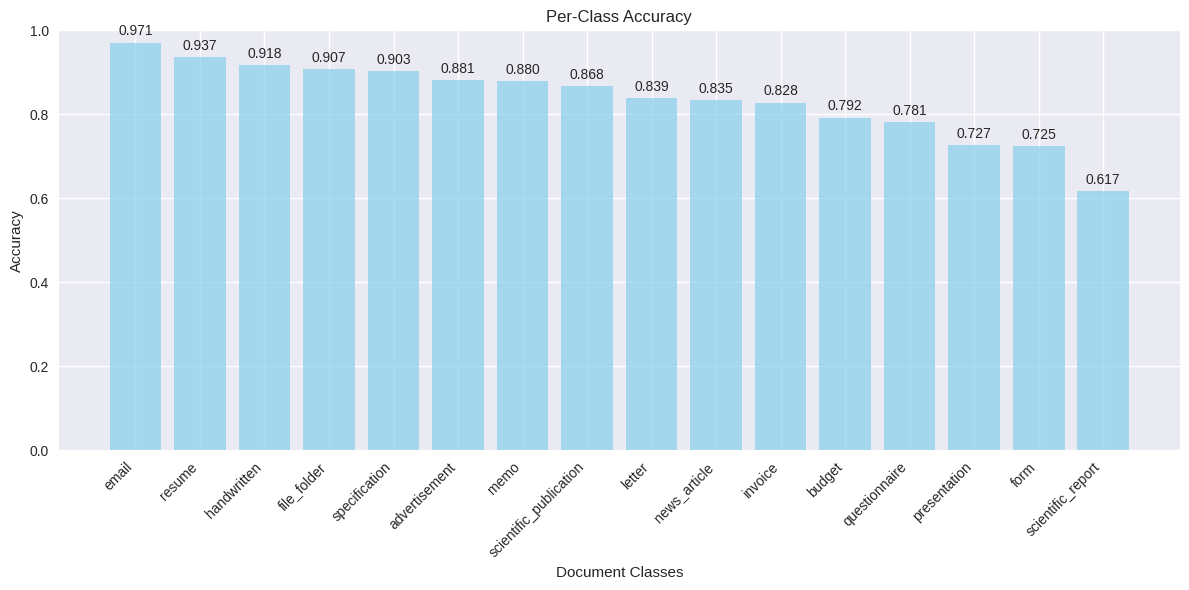

In [16]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/normalized_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print("=" * 60)
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Save classification report
with open('/kaggle/working/classification_report.txt', 'w') as f:
    f.write("Classification Report\n")
    f.write("=" * 60 + "\n")
    f.write(report)
print("Classification report saved to: /kaggle/working/classification_report.txt")

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
accuracy_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': class_accuracies,
    'Support': cm.sum(axis=1)
}).sort_values('Accuracy', ascending=False)

print("\nPer-Class Accuracy:")
print(accuracy_df)

# Save per-class accuracy
accuracy_df.to_csv('/kaggle/working/per_class_accuracy.csv', index=False)
print("Per-class accuracy saved to: /kaggle/working/per_class_accuracy.csv")

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
plt.bar(accuracy_df['Class'], accuracy_df['Accuracy'], color='skyblue', alpha=0.7)
plt.title('Per-Class Accuracy')
plt.xlabel('Document Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for i, v in enumerate(accuracy_df['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('/kaggle/working/per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

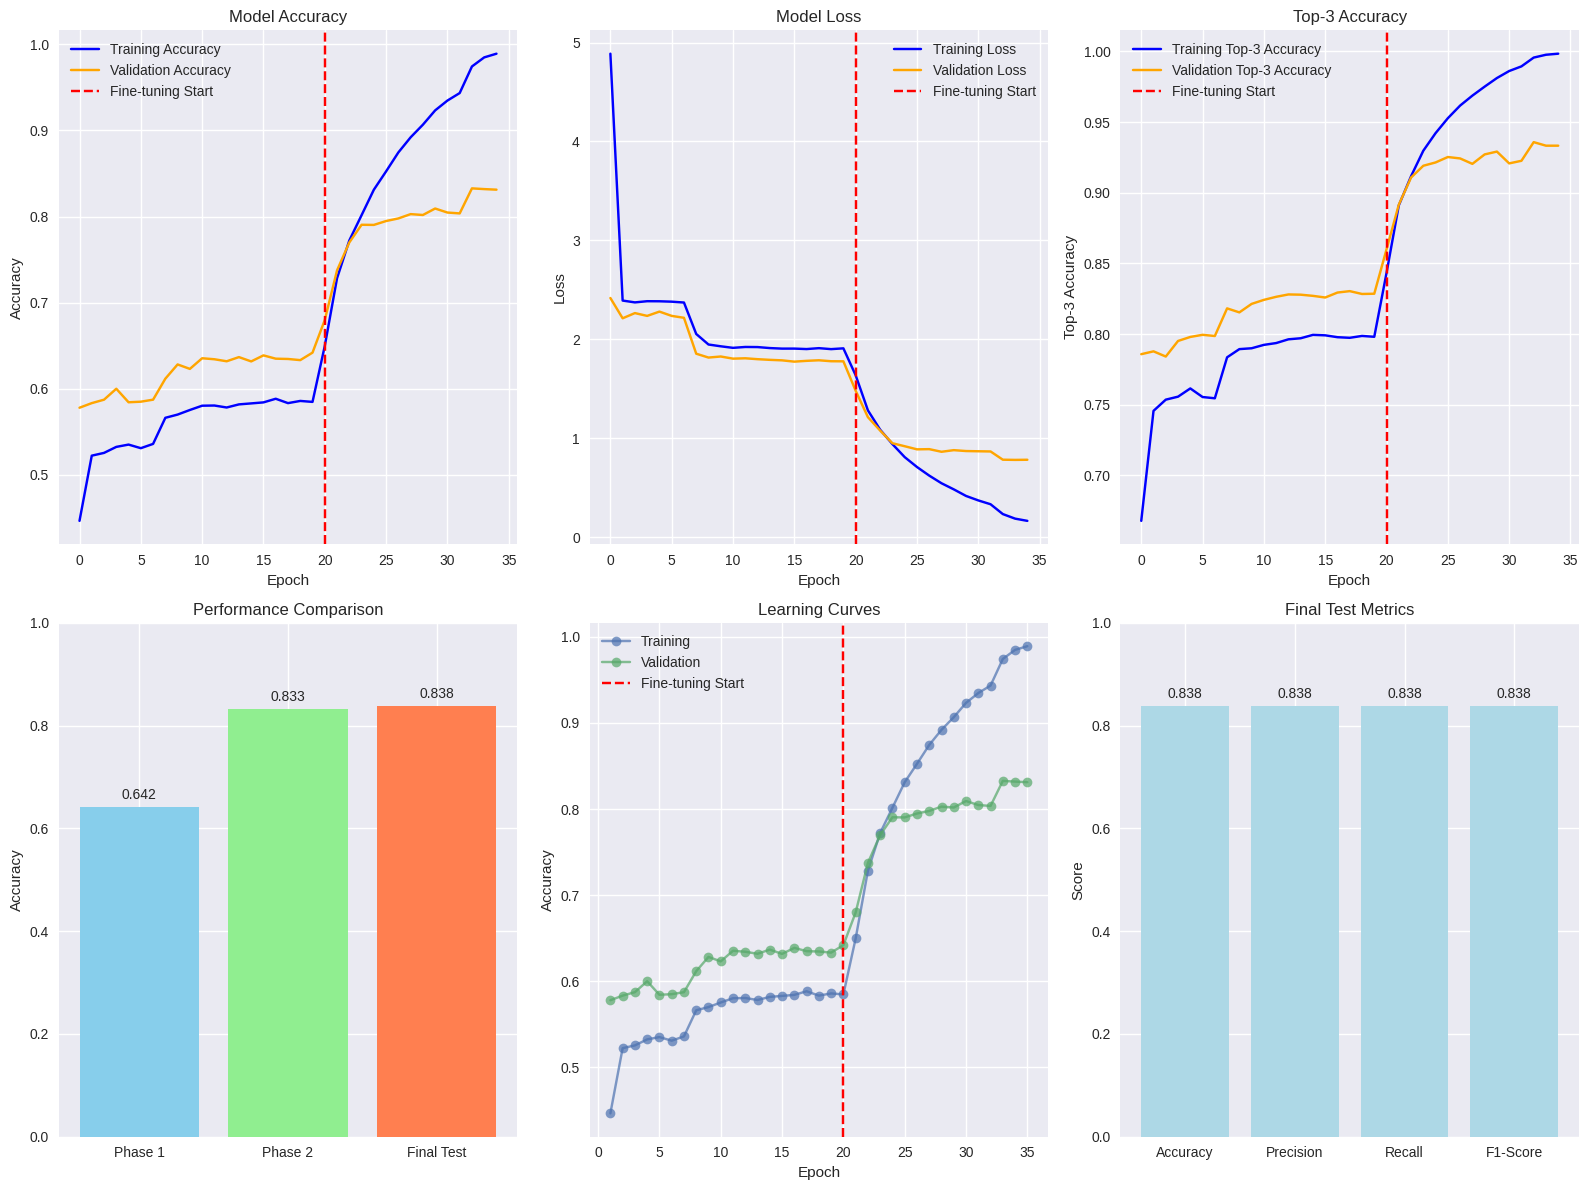

Training history saved to: /kaggle/working/training_history.csv

Training Summary:
Total training epochs: 35
Best validation accuracy: 0.8327
Final test accuracy: 0.8382
Best validation loss: 0.7812
Final test loss: 0.7894
Training summary saved to: /kaggle/working/training_summary.csv

Model Performance Insights:
Best performing classes: email, resume, handwritten
Worst performing classes: presentation, form, scientific_report
Average per-class accuracy: 0.8378
Standard deviation: 0.0920


In [17]:
# Combine training histories for comprehensive analysis
def combine_training_histories(history1, history2):
    """Combine two training histories."""
    combined_history = {}
    
    for key in history1.history.keys():
        if key in history2.history:
            combined_history[key] = history1.history[key] + history2.history[key]
        else:
            combined_history[key] = history1.history[key]
    
    return combined_history

# Combine both phases
if 'history_phase1' in locals() and 'history_phase2' in locals():
    combined_history = combine_training_histories(history_phase1, history_phase2)
    
    # Plot combined training history
    plt.figure(figsize=(16, 12))
    
    # Training and validation accuracy
    plt.subplot(2, 3, 1)
    plt.plot(combined_history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(combined_history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', 
                label='Fine-tuning Start')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Training and validation loss
    plt.subplot(2, 3, 2)
    plt.plot(combined_history['loss'], label='Training Loss', color='blue')
    plt.plot(combined_history['val_loss'], label='Validation Loss', color='orange')
    plt.axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', 
                label='Fine-tuning Start')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Top-3 accuracy
    plt.subplot(2, 3, 3)
    if 'top_3_accuracy' in combined_history:
        plt.plot(combined_history['top_3_accuracy'], label='Training Top-3 Accuracy', color='blue')
        plt.plot(combined_history['val_top_3_accuracy'], label='Validation Top-3 Accuracy', color='orange')
        plt.axvline(x=len(history_phase1.history['top_3_accuracy']), color='red', linestyle='--', 
                    label='Fine-tuning Start')
        plt.title('Top-3 Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Top-3 Accuracy')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Top-3 Accuracy\nNot Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Top-3 Accuracy')
    
    # Performance comparison
    plt.subplot(2, 3, 4)
    phases = ['Phase 1', 'Phase 2', 'Final Test']
    accuracies = [
        max(history_phase1.history['val_accuracy']),
        max(history_phase2.history['val_accuracy']),
        accuracy
    ]
    bars = plt.bar(phases, accuracies, color=['skyblue', 'lightgreen', 'coral'])
    plt.title('Performance Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Learning curves
    plt.subplot(2, 3, 5)
    train_sizes = np.arange(1, len(combined_history['accuracy']) + 1)
    plt.plot(train_sizes, combined_history['accuracy'], 'o-', label='Training', alpha=0.7)
    plt.plot(train_sizes, combined_history['val_accuracy'], 'o-', label='Validation', alpha=0.7)
    plt.axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', 
                label='Fine-tuning Start')
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Final metrics summary
    plt.subplot(2, 3, 6)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]
    bars = plt.bar(metrics, values, color='lightblue')
    plt.title('Final Test Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/comprehensive_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save training history data
    import pandas as pd
    history_df = pd.DataFrame(combined_history)
    history_df.to_csv('/kaggle/working/training_history.csv', index=False)
    print("Training history saved to: /kaggle/working/training_history.csv")
    
    # Summary statistics
    print("\nTraining Summary:")
    print("=" * 50)
    print(f"Total training epochs: {len(combined_history['accuracy'])}")
    print(f"Best validation accuracy: {max(combined_history['val_accuracy']):.4f}")
    print(f"Final test accuracy: {accuracy:.4f}")
    print(f"Best validation loss: {min(combined_history['val_loss']):.4f}")
    print(f"Final test loss: {test_results[0]:.4f}")
    
    # Save summary statistics
    summary_stats = {
        'Total Epochs': len(combined_history['accuracy']),
        'Best Validation Accuracy': max(combined_history['val_accuracy']),
        'Final Test Accuracy': accuracy,
        'Best Validation Loss': min(combined_history['val_loss']),
        'Final Test Loss': test_results[0],
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1-Score': f1
    }
    
    summary_df = pd.DataFrame(list(summary_stats.items()), columns=['Metric', 'Value'])
    summary_df.to_csv('/kaggle/working/training_summary.csv', index=False)
    print("Training summary saved to: /kaggle/working/training_summary.csv")
    
    # Model performance insights
    print("\nModel Performance Insights:")
    print("=" * 50)
    best_classes = accuracy_df.head(3)
    worst_classes = accuracy_df.tail(3)
    print(f"Best performing classes: {', '.join(best_classes['Class'].values)}")
    print(f"Worst performing classes: {', '.join(worst_classes['Class'].values)}")
    print(f"Average per-class accuracy: {accuracy_df['Accuracy'].mean():.4f}")
    print(f"Standard deviation: {accuracy_df['Accuracy'].std():.4f}")
    
else:
    print("Training histories not found. Please run the training cells first.")

Model saved successfully!
Model architecture saved!
Label encoder saved!

Testing prediction on random test images:

Image 1: 0060348562.tif
True label: invoice
Predicted: form (confidence: 0.977)
Top 3 predictions: [('form', 0.97691435), ('invoice', 0.019773377), ('specification', 0.00079519465)]

Image 2: 91659478_9479.tif
True label: advertisement
Predicted: advertisement (confidence: 1.000)
Top 3 predictions: [('advertisement', 0.9999329), ('news_article', 3.8078026e-05), ('questionnaire', 1.4814503e-05)]

Image 3: 1003655928.tif
True label: specification
Predicted: specification (confidence: 0.856)
Top 3 predictions: [('specification', 0.8555811), ('budget', 0.12209043), ('scientific_report', 0.01707876)]

Image 4: 2085780630e_0631.tif
True label: email
Predicted: email (confidence: 1.000)
Top 3 predictions: [('email', 0.9999447), ('letter', 1.5262238e-05), ('form', 9.229503e-06)]

Image 5: 506338423.tif
True label: specification
Predicted: invoice (confidence: 0.994)
Top 3 predic

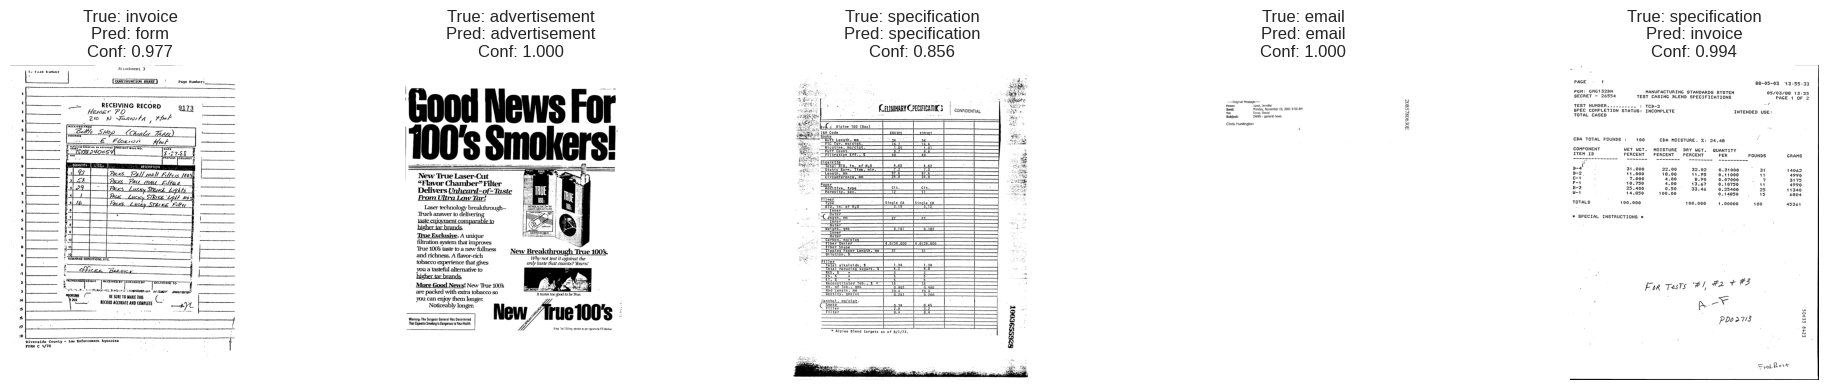


Prediction pipeline ready!
Use predict_document_class(image_path) to classify new documents.


In [18]:
# Save the final model
model.save('/kaggle/working/vgg16_document_classifier.h5')
print("Model saved successfully!")

# Save model architecture as JSON
model_json = model.to_json()
with open('/kaggle/working/vgg16_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved!")

# Save label encoder
import pickle
with open('/kaggle/working/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved!")

# Function to predict single image
def predict_single_image(model, image_path, label_encoder):
    """
    Predict the class of a single image.
    """
    try:
        # Preprocess image
        img = preprocess_image(image_path)
        img_batch = np.expand_dims(img, axis=0)
        img_batch = tf.keras.applications.vgg16.preprocess_input(img_batch * 255.0)
        
        # Get prediction
        prediction = model.predict(img_batch, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = label_encoder.classes_[predicted_class_idx]
        confidence = prediction[0][predicted_class_idx]
        
        # Get top 3 predictions
        top_3_indices = np.argsort(prediction[0])[-3:][::-1]
        top_3_predictions = [(label_encoder.classes_[idx], prediction[0][idx]) 
                            for idx in top_3_indices]
        
        return predicted_class, confidence, top_3_predictions
    
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, None, None

# Test prediction on a few random test images
print("\nTesting prediction on random test images:")
print("=" * 50)

n_examples = 5
random_indices = np.random.choice(len(X_test), n_examples, replace=False)

plt.figure(figsize=(20, 4))
for i, idx in enumerate(random_indices):
    img_path = X_test[idx]
    true_label = y_test[idx]
    
    # Make prediction
    pred_class, confidence, top_3 = predict_single_image(model, img_path, label_encoder)
    
    # Load and display image
    img = Image.open(img_path)
    plt.subplot(1, n_examples, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {pred_class}\nConf: {confidence:.3f}')
    plt.axis('off')
    
    # Print detailed prediction
    print(f"\nImage {i+1}: {img_path.name}")
    print(f"True label: {true_label}")
    print(f"Predicted: {pred_class} (confidence: {confidence:.3f})")
    print(f"Top 3 predictions: {top_3}")

plt.tight_layout()
plt.savefig('/kaggle/working/prediction_examples.png', dpi=150, bbox_inches='tight')
plt.show()

# Create a prediction function for new images
def predict_document_class(image_path, model_path=None):
    """
    Complete prediction pipeline for new document images.
    """
    if model_path:
        # Load model if path provided
        loaded_model = tf.keras.models.load_model(model_path)
        # Load label encoder
        with open('/kaggle/working/label_encoder.pkl', 'rb') as f:
            loaded_label_encoder = pickle.load(f)
    else:
        loaded_model = model
        loaded_label_encoder = label_encoder
    
    return predict_single_image(loaded_model, image_path, loaded_label_encoder)

print("\nPrediction pipeline ready!")
print("Use predict_document_class(image_path) to classify new documents.")

## 7. Conclusion and Next Steps

### Summary of Results

This notebook implemented a comprehensive VGG16 transfer learning pipeline for document classification on the RVL-CDIP dataset. The key achievements include:

1. **Data Handling**: Successfully loaded and processed the dataset with stratified splitting
2. **Data Analysis**: Performed thorough exploratory data analysis with visualizations
3. **Preprocessing**: Implemented robust image preprocessing with quality checks
4. **Model Architecture**: Built a VGG16-based model with custom classification head
5. **Training**: Executed two-phase training (frozen base + fine-tuning)
6. **Evaluation**: Comprehensive evaluation with multiple metrics and visualizations

### Files Generated in /kaggle/working/
- `vgg16_document_classifier.h5`: Final trained model
- `best_vgg16_model.h5`: Best model from Phase 1
- `best_vgg16_finetuned.h5`: Best model from Phase 2
- `vgg16_architecture.json`: Model architecture
- `label_encoder.pkl`: Label encoder for class mapping
- `training_log.csv`: Training metrics log
- `training_history.csv`: Combined training history
- `training_summary.csv`: Summary statistics
- `classification_report.txt`: Detailed classification report
- `per_class_accuracy.csv`: Per-class performance metrics
- `vgg16_model.png`: Model architecture visualization
- Various training and analysis plots saved as PNG files
- `logs/`: TensorBoard logs directory

### Usage
The model is ready for deployment and can be used to classify new document images using the `predict_document_class()` function.